# Supervised NN on Stock Market Data
### Dan Schmidt's Script Fall 2016

In [1]:
%reload_ext autoreload
%load_ext autoreload
%autoreload 2
import os
import sys

# add the 'src' directory as one where we can import modules
src_dir = os.path.join(os.getcwd(), os.pardir, 'src')
sys.path.append(src_dir)
%aimport preprocess
from preprocess.process import get_symbol
from preprocess.process import get_symbols_matrix
from preprocess.process import df_to_returns
from preprocess.process import get_windows_rets
from preprocess.process import get_volume_windows

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os.path
from IPython.core.debugger import Tracer
import scipy as sp

from keras.models import Model
from keras.layers import Input, Dense
from keras.regularizers import l2, activity_l2

import theano
import theano.tensor as T

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Using Theano backend.
Using gpu device 0: GeForce GTX 750 Ti (CNMeM is disabled, cuDNN Mixed dnn version. The header is from one version, but we link with a different version (5005, 5105))


In [ ]:
# Load in the data
# Use tickers in the Dow Jones for most of this analysis
data_loc = "/home/dan/code/market_data/"
symbols = [line.rstrip('\n') for line in open(data_loc+'dow_jones_industrial.txt')]

train_start_date = "01/01/2013"
train_end_date = "01/01/2014"

test_start_date = "01/01/2014"
test_end_date = "01/31/2014"

from random import shuffle
test_symbols = symbols
shuffle(test_symbols)

window_length = 15
profit = {}
sharpes = {}

# Overall neural model trained on 3 million data points :D
middle_dim = window_length
encoding_dim = 10
reg = 0

input_w = Input(shape=(2*window_length,))

in_layer = Dense(
    middle_dim,
    init='normal',
    activation='tanh',
    W_regularizer=l2(reg))(input_w)

mid_layer = Dense(
    encoding_dim,
    init='normal', 
    activation='tanh',
    W_regularizer=l2(reg))(in_layer)

output = Dense(
    1,
    init='normal',
    activation='linear')(in_layer)

mlp_pred_big = Model(input=input_w, output=output)
mlp_pred_big.compile(optimizer='adagrad', loss='mse')

for sym in test_symbols:
    symb = get_symbol(sym, data_loc, train_start_date, train_end_date)
    sym_rets, sym_y = get_windows_rets(symb, window_length=window_length, window_offset=1, forward=(1,2))
    sym_vol = get_volume_windows(symb, window_length=window_length)

    test_aapl = get_symbol(sym, data_loc, test_start_date, test_end_date)
    test_rets, test_y = get_windows_rets(test_aapl, window_length=window_length, window_offset=1, forward=(1,2))
    test_vol = get_volume_windows(test_aapl, window_length=window_length)
    
    # Train the local model
    middle_dim = window_length
    encoding_dim = 10
    reg = 0
    ret_std = 1e-1*np.std(sym_y)

    print(ret_std)

    input_w = Input(shape=(2*window_length,))

    in_layer = Dense(
        middle_dim,
        init='normal',
        activation='tanh',
        W_regularizer=l2(reg))(input_w)

    mid_layer = Dense(
        encoding_dim,
        init='normal', 
        activation='tanh',
        W_regularizer=l2(reg))(in_layer)

    output = Dense(
        1,
        init='normal',
        activation='linear')(in_layer)

    mlp_pred = Model(input=input_w, output=output)
    mlp_pred.compile(optimizer='adagrad', loss='mse')

    sym_f = np.concatenate( (sym_rets, sym_vol), axis=1)
    feature_std = np.std(sym_f, axis=0)
    feature_mean = np.mean(sym_f, axis=0)
    mlp_pred.fit(
        (sym_f-feature_mean) / feature_std, 
        sym_y[:, 0] / ret_std, 
        batch_size=100,
        nb_epoch=32,
        shuffle=True
    )
    
    mlp_pred_big.train_on_batch((sym_f-feature_mean) / feature_std,sym_y[:, 0] / ret_std )
    mlp_pred.save('../models/'+sym)
    # 
    # Try a trading strategy

    n_buys = 0
    n_sells = 0
    no_trades = 0
    pnl = np.zeros( (len(test_rets), 1) )
    pnls = np.zeros( (len(test_rets), 1) )
    test_f = np.concatenate( (test_rets, test_vol), axis=1)

    capital = 10000
    last_money = capital
    feats = test_f / feature_std
    preds = mlp_pred.predict(feats) * ret_std
    pred_thresh = 2*np.std(preds)
    for wi in range(len(test_rets)):
        pred = preds[wi]
        if (np.abs(pred) > pred_thresh):
            if (pred > 0):
                n_buys += 1
                pnl[wi] = last_money*(1+test_y[wi, 0])
                pnls[wi] = test_y[wi, 0]
            if (pred < 0):
                n_sells += 1
                pnl[wi] = last_money*(1-test_y[wi, 0])
                pnls[wi] = -test_y[wi, 0]

        else:
            no_trades += 1
            pnl[wi] = last_money
        last_money = pnl[wi]

    print("Sym: ", sym)
    print("Buys: ", n_buys)
    print("Sells: ", n_sells)
    print("Final Profit: ", (last_money/capital - 1))
    print("Sharpe:")
    pos_pnls = pnls[np.abs(pnls) > 0]
    sharpe = np.sqrt(12*(n_buys+n_sells))*np.mean((pos_pnls)) / np.std(pos_pnls)
    print(sharpe)
    profit[sym] = last_money
    sharpes[sym] = sharpe

mlp_pred_big.save('../models/big_supervised')

Reading UNH from pickle


## Define the Model

In [28]:
for sym in sorted(symbols):
    prof = (profit[sym]-10000)/10000
    print("%s & %.2f & %.2f \\\\" % ( sym, prof[0]*100,sharpes[sym]))

AAPL & 0.16 & 0.37 \\
AXP & 1.30 & 3.13 \\
BA & 1.16 & 1.88 \\
CAT & 5.73 & 10.10 \\
CSCO & -0.97 & -3.11 \\
CVX & 0.58 & 2.07 \\
DD & 0.43 & 1.19 \\
DIS & -0.16 & -0.42 \\
GE & 1.49 & 4.77 \\
GS & -2.26 & -6.06 \\
HD & 2.01 & 5.94 \\
IBM & 0.68 & 2.05 \\
INTC & -3.07 & -8.21 \\
JNJ & 0.67 & 2.03 \\
JPM & 0.35 & 0.91 \\
KO & 0.34 & 1.06 \\
MCD & -0.88 & -2.65 \\
MMM & 3.63 & 10.99 \\
MRK & 3.22 & 7.35 \\
MSFT & 0.65 & 1.55 \\
NKE & 2.08 & 6.04 \\
PFE & 2.92 & 7.19 \\
PG & 1.57 & 4.61 \\
TRV & 0.36 & 1.39 \\
UNH & 2.86 & 6.65 \\
UTX & 1.99 & 4.59 \\
V & 4.83 & 9.29 \\
VZ & -1.32 & -3.22 \\
WMT & 2.21 & 7.10 \\
XOM & 1.16 & 3.73 \\


7.49207086874e-05


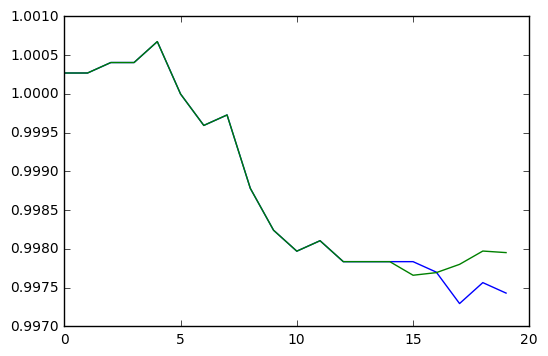

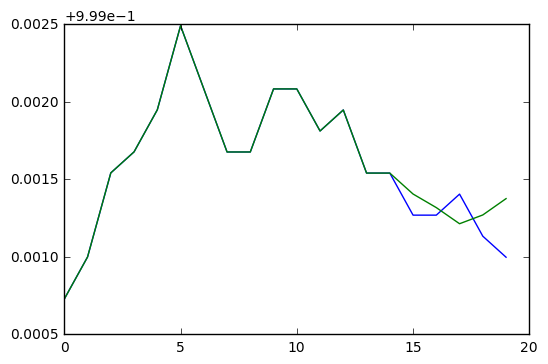

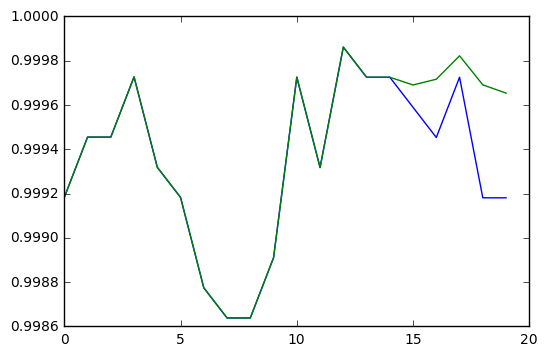

In [5]:
# Plot prediction
print(ret_std)
idxs = np.random.rand(3)
idxs = map(int, np.round(idxs*1000))
for idx in idxs:
    forward = 5
    window = val_rets[idx,:]
    actual = np.zeros(window_length+forward)
    actual[0:window_length] = window
    actual[forward:] = val_rets[idx+forward, :]
    preds = np.zeros(window_length+forward)
    preds[0:window_length] = window
    for i in range(forward):
        feats = val_f[idx+i, :] / feature_std
        p = mlp_pred.predict( np.matrix(feats) ) * ret_std*10
        preds[window_length+i] = p

    plt.plot( np.cumprod(1+actual) )
    plt.plot(np.cumprod(1+preds) )
    plt.show()

(30, 15)


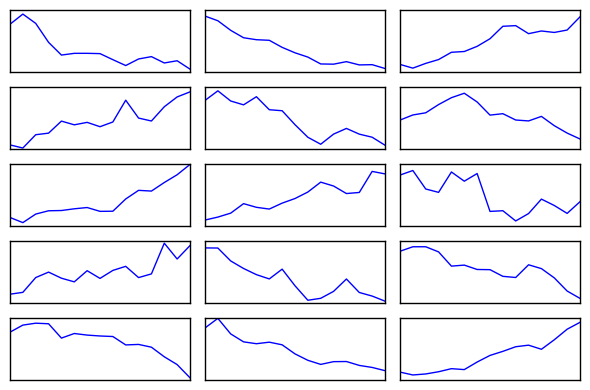

In [31]:

# Visualize the learned features
w0 = mlp_pred_big.get_weights()[0]
print(w0.shape)
fig, axes = plt.subplots(nrows=5, ncols=3)
ri = 0
ci = 0
for wi in range(15):
    learned = w0[:15, wi]
    axes[ri, ci].plot((1+learned).cumprod())
    axes[ri, ci].get_xaxis().set_visible(False)
    axes[ri, ci].get_yaxis().set_visible(False)
    ci += 1
    if ci == 3:
        ri += 1
        ci = 0
plt.tight_layout()
plt.savefig('mlp_feats_big.png')
plt.show()

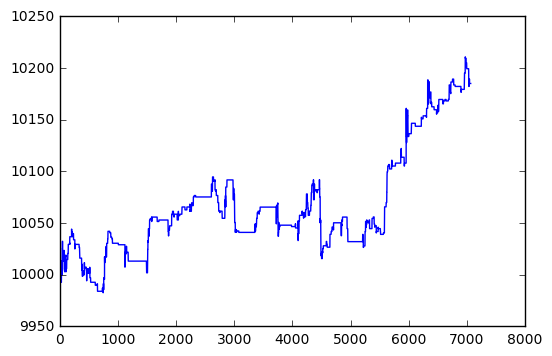

Buys:  53
Sells:  441
Final Profit:  [ 0.01851347]
Sharpe:
4.54685198273


In [6]:
# Try a trading strategy

n_buys = 0
n_sells = 0
no_trades = 0
pnl = np.zeros( (len(test_rets), 1) )
pnls = np.zeros( (len(test_rets), 1) )
test_f = np.concatenate( (test_rets, test_vol), axis=1)

capital = 10000
last_money = capital
feats = test_f / feature_std
preds = mlp_pred.predict(feats) * ret_std
pred_thresh = 2*np.std(preds)
for wi in range(len(test_rets)):
    pred = preds[wi]
    if (np.abs(pred) > pred_thresh):
        if (pred > 0):
            n_buys += 1
            pnl[wi] = last_money*(1+test_y[wi, 0])
            pnls[wi] = test_y[wi, 0]
        if (pred < 0):
            n_sells += 1
            pnl[wi] = last_money*(1-test_y[wi, 0])
            pnls[wi] = -test_y[wi, 0]

    else:
        no_trades += 1
        pnl[wi] = last_money
    last_money = pnl[wi]
    
plt.plot(pnl)
plt.show()

print("Buys: ", n_buys)
print("Sells: ", n_sells)
print("Final Profit: ", (last_money/capital - 1))

print("Sharpe:")
pos_pnls = pnls[np.abs(pnls) > 0]
sharpe = np.sqrt(12*(n_buys+n_sells))*np.mean((pos_pnls)) / np.std(pos_pnls)
print(sharpe)


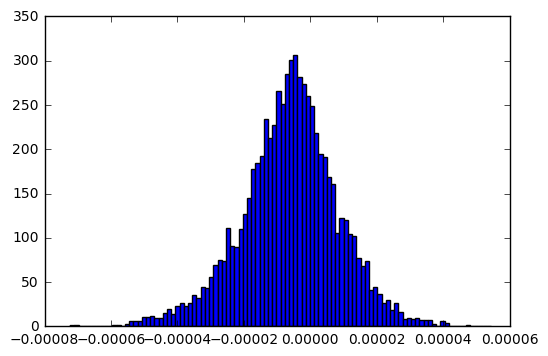

1.47592e-05
-6.32243e-06


In [186]:

plt.hist(preds, 100)
plt.show()

print(np.std(preds))
print(np.mean(preds))

In [171]:
dir(mlp_pred)

['__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_collected_trainable_weights',
 '_fit_loop',
 '_function_kwargs',
 '_get_node_attribute_at_index',
 '_make_predict_function',
 '_make_test_function',
 '_make_train_function',
 '_output_mask_cache',
 '_output_shape_cache',
 '_output_tensor_cache',
 '_predict_loop',
 '_standardize_user_data',
 '_test_loop',
 '_updated_config',
 'add_inbound_node',
 'assert_input_compatibility',
 'build',
 'built',
 'call',
 'compile',
 'compute_mask',
 'constraints',
 'container_nodes',
 'count_params',
 'create_input_layer',
 'evaluate',
 'evaluate_generator',
 'fit',
 'fit_generator',
 'from_config',
 'get_config',
 'get_input_at',
 'get_input_ma

In [ ]:
# Bayesian MLP

# Hyperparameters
middle_dim = window_length
encoding_dim = 10
reg = 1e-12
ret_thresh = 1e-2

input_w = Input(shape=(2*window_length,))

in_layer = Dense(
    middle_dim,
    init='normal',
    activation='tanh',
    W_regularizer=l2(reg))(input_w)

mid_layer = Dense(
    encoding_dim,
    init='normal', 
    activation='tanh',
    W_regularizer=l2(reg))(in_layer)

output = Dense(
    1,
    init='normal',
    activation='sigmoid')(mid_layer)

mlp_pred = Model(input=input_w, output=output)
mlp_pred.compile(optimizer='adam', loss='binary_crossentropy')

dm_y = (np.abs(aapl_y[:, 0]) > ret_thresh)*(1 / (2*aapl_y[:,0]))+0.5
dm_val = (np.abs(val_y[:,0]) > ret_thresh)*(1 / (2*val_y[:,0]))+0.5

aapl_f = np.concatenate( (aapl_rets, aapl_vol), axis=1)
val_f = np.concatenate( (val_rets, val_vol), axis=1)

mlp_pred.fit(
    aapl_f, 
    dm_y, 
    batch_size=100,
    nb_epoch=25,
    shuffle=True, 
    validation_data=(val_f, dm_val) 
)
